# Описание проекта

Компания - оператор такси желает привлекать дополнительных водителей в период пиковой нагрузки в аэропортах. Для этого необходимо спрогнозировать количество заказов такси на следующий час.

### Метрики

*RMSE* < 48.

# 1. Подготовка

## Загрузка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dt
import itertools

from IPython.display import display as d
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

Настроим среду.

In [2]:
sns.set()
warnings.filterwarnings('ignore')
r_state = 123

Откроем файл и загрузим данные.

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

d(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


## Предобработка (проверка) данных

Проверим индекс на наличие дубликатов.

In [4]:
data.index.duplicated().sum()

0

Проверим *num_orders* на наличие выбросов, аномалий.

In [5]:
data.num_orders.describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

In [6]:
data.sort_values(by='num_orders', ascending=False).head(10)

,num_orders
datetime,
2018-08-27 02:10:00,119
2018-08-13 02:20:00,119
2018-08-13 02:30:00,99
2018-08-27 02:00:00,98
2018-08-30 17:50:00,95
2018-08-20 02:20:00,94
2018-08-20 04:00:00,91
2018-08-20 02:10:00,90
2018-08-20 02:00:00,87


Дубликатов, выбросов, аномалий в данных нет.

Выполним ресемплирование. Агрегирующая функция - суммирование, так как нам необходимо знать суммарное количество заказов в течение каждого часа.

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные подготовлены. Можно приступать к их анализу.

# 2. Анализ

## Функции

In [8]:
# The function plots the time series passed
def ts_plot(data, title='', ticks='', hue=None):
    plt.figure(figsize=(16, 6))
    
    if title != '':
        plt.suptitle(f'Number of orders ({title})')
    else:
        plt.suptitle('Number of orders')

    sns.lineplot(x=data.index, y='num_orders', hue=hue, data=data)
    
    if ticks == 'w':
        plt.xticks(np.arange(data.index.min(), data.index.max(), dt.timedelta(days=7)), rotation=45)
    elif ticks == 'd':
        plt.xticks(np.arange(data.index.min(), data.index.max(), dt.timedelta(days=1)), rotation=45)
    elif ticks == 'h':
        plt.xticks(np.arange(data.index.min(), data.index.max(), dt.timedelta(seconds=3600)),
                   np.arange(0, 24, 1),
                   rotation=45)
        plt.xlim((data.index.min(), data.index.max()))
    
    plt.show()

In [9]:
# The function plots the two plots for comparing
def plots_comparing(row_1, legend_1, row_2, legend_2, suptitle):
    plt.figure(figsize=(16, 6))
    plt.suptitle(suptitle)
    legend = []

    plt.plot(row_1.index, 'num_orders', data=row_1)
    legend.append(legend_1)

    plt.plot(row_2.index, 'num_orders', ':', lw=3, data=row_2)
    legend.append(legend_2)

    plt.legend(legend)
    plt.show()

## Данные за весь период


Построим график.

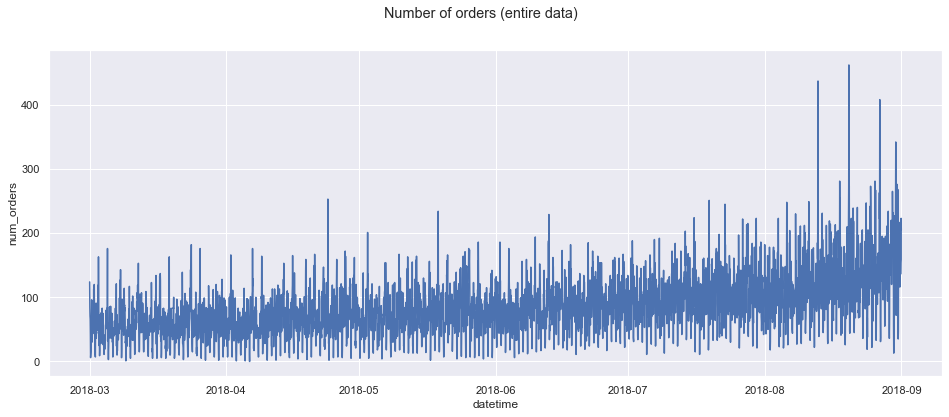

In [10]:
ts_plot(data, title='entire data')

Количество вызовов изменяется в течение суток в широких пределах. Однако, просматривается **восходящий** тренд.

График получился малоинформативным: слишком мелкий масштаб. Попробуем увеличить его.

## Данные за месяц

Для большей наглядности построим график за один месяц.

In [11]:
slice_bounds_month = ['2018-08', '2018-09']

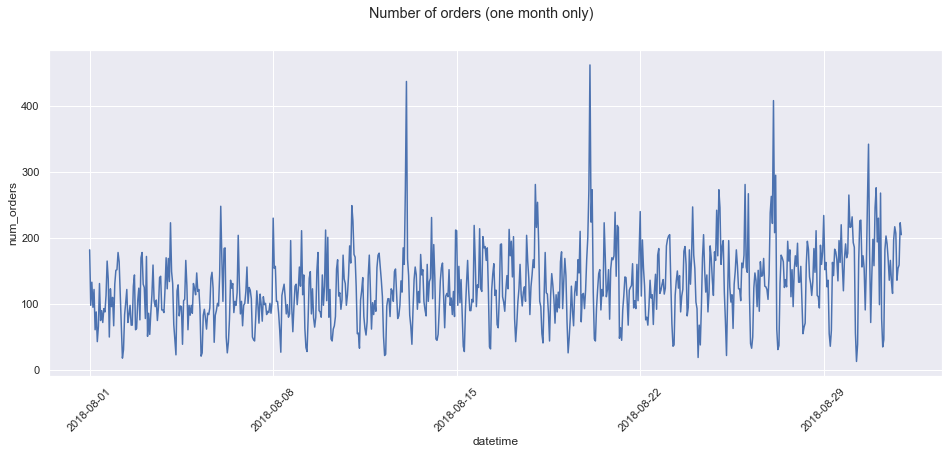

In [12]:
ts_plot(data[slice_bounds_month[0]:slice_bounds_month[1]],
        title='one month only',
        ticks='w')

Разложим временной ряд на составляющие: тренд, сезонность, остаток.

Построим графики этих составляющих. Будем строить за тот же период (за последний месяц).

In [13]:
decomposed = seasonal_decompose(data)

decomposed_trend = pd.DataFrame(data=decomposed.trend.values, index=decomposed.trend.index, columns=data.columns)
decomposed_seasonal = pd.DataFrame(data=decomposed.seasonal.values, index=decomposed.seasonal.index, columns=data.columns)
decomposed_resid = pd.DataFrame(data=decomposed.resid.values, index=decomposed.resid.index, columns=data.columns)

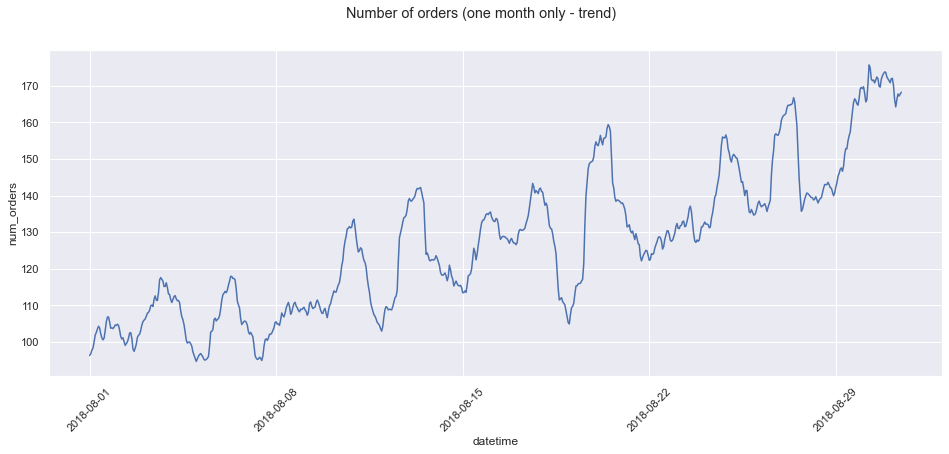

In [14]:
ts_plot(decomposed_trend[slice_bounds_month[0]:slice_bounds_month[1]],
        title='one month only - trend',
        ticks='w')

Виден восходящий тренд и некоторые **циклические** колебания. Они не эквивалентны друг другу строго, но имеют **схожий** характер.

Восходящий тренд говорит об общем росте числа заказов. Из графиков выше следует, что этот рост весьма устойчив и стабилен.

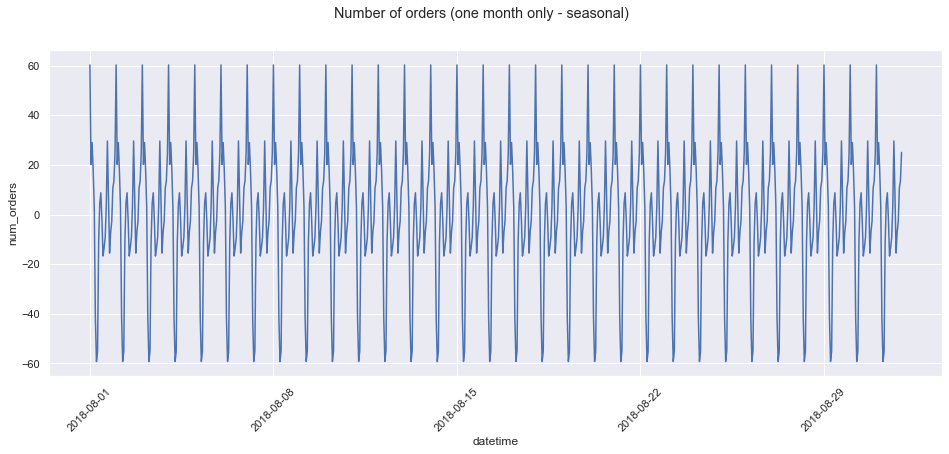

In [15]:
ts_plot(decomposed_seasonal[slice_bounds_month[0]:slice_bounds_month[1]],
        title='one month only - seasonal',
        ticks='w')

Длина цикла сезонной составляющей - **одни сутки** (7 циклов в неделю).

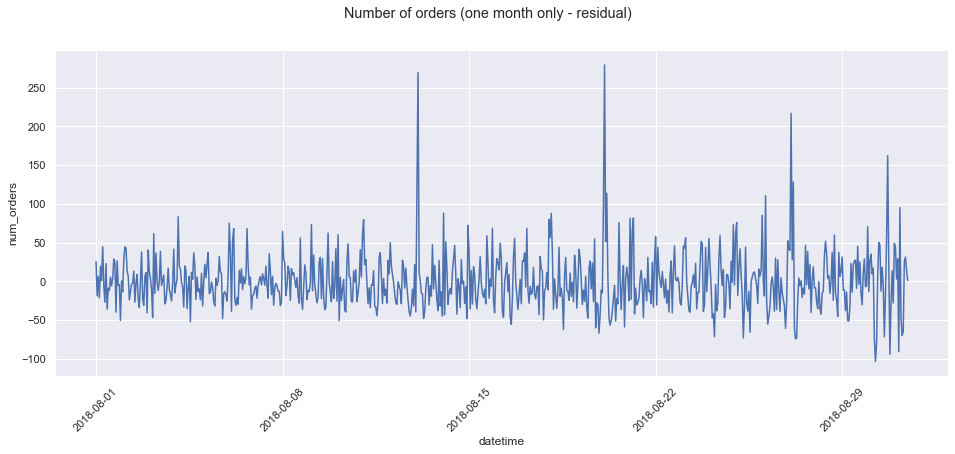

In [16]:
ts_plot(decomposed_resid[slice_bounds_month[0]:slice_bounds_month[1]],
        title='one month only - residual',
        ticks='w')

Выбросы, которые видны на исходном графике, отнесены алгоритмом к остаткам. Остатки колеблются в достаточно широких пределах: фактор случайности оказывает **значительное** влияние на количество вызовов.

## Данные за неделю

### Границы среза

Чтобы детальнее рассмотреть недельную сезонность, построим графики за одну неделю.

In [17]:
slice_bounds_week = ['2018-08-20', '2018-08-27']

### Последовательность выполнения декомпозиции и среза

Вначале проверим, насколько велика разница между разложением, рассчитанным по всему датасету (за несколько месяцев), и разложением, рассчитанным по срезу. Сделаем это именно сейчас, так как разница (если она вообще есть) между несколькими месяцами и одной неделей будет более заметна, чем между несколькими месяцами и одним месяцем (рассмотренным выше).

In [18]:
data_week = data[slice_bounds_week[0]:slice_bounds_week[1]]
decomposed_week = seasonal_decompose(data_week)
decomposed_week_trend = pd.DataFrame(data=decomposed_week.trend.values,
                                     index=decomposed_week.trend.index,
                                     columns=data.columns)

np.array_equal(decomposed_week_trend.num_orders.values,
               decomposed_trend[slice_bounds_week[0]:slice_bounds_week[1]].num_orders.values)

False

Массивы не эквивалентны друг другу.

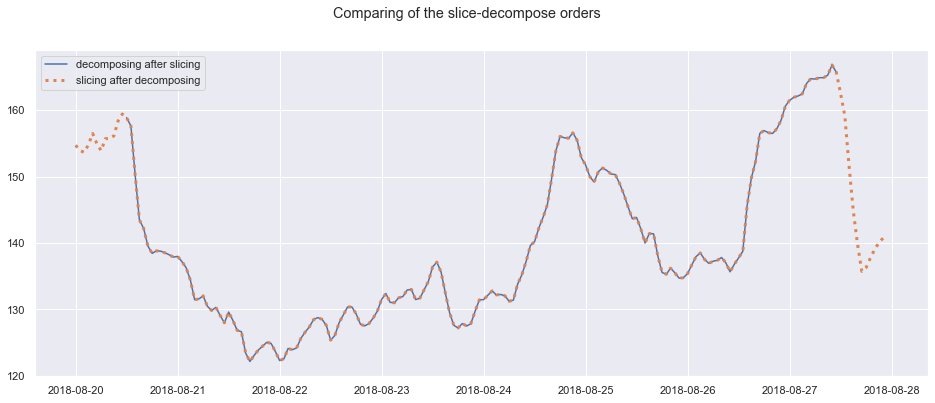

In [19]:
plots_comparing(decomposed_week_trend,
                'decomposing after slicing',
                decomposed_trend[slice_bounds_week[0]:slice_bounds_week[1]],
                'slicing after decomposing',
                'Comparing of the slice-decompose orders'
               )

Разница между массивами есть, но на графике видно, что она - **незначительная**.

Более корректным представляется вариант, когда мы выполняем разложение по всему датасету, а потом уже берём из полученного разложения необходимые срезы ("slicing after decomposing" - оранжевые точки на графике). Нас интересуют полные данные, и расчёты, связанные с выявлением тренда и сезонности, должны отталкиваться именно от полного набора данных, а не от какого-либо среза.

Поэтому будем работать с разложением **всего датасета** и брать из него необходимые срезы, а делать разложения срезов - не будем.

### Анализ среза и составляющих его разложения

In [20]:
data[slice_bounds_week[0]:slice_bounds_week[1]].num_orders.describe()

count    192.000000
mean     141.838542
std       62.656380
min       19.000000
25%      107.750000
50%      136.000000
75%      172.250000
max      462.000000
Name: num_orders, dtype: float64

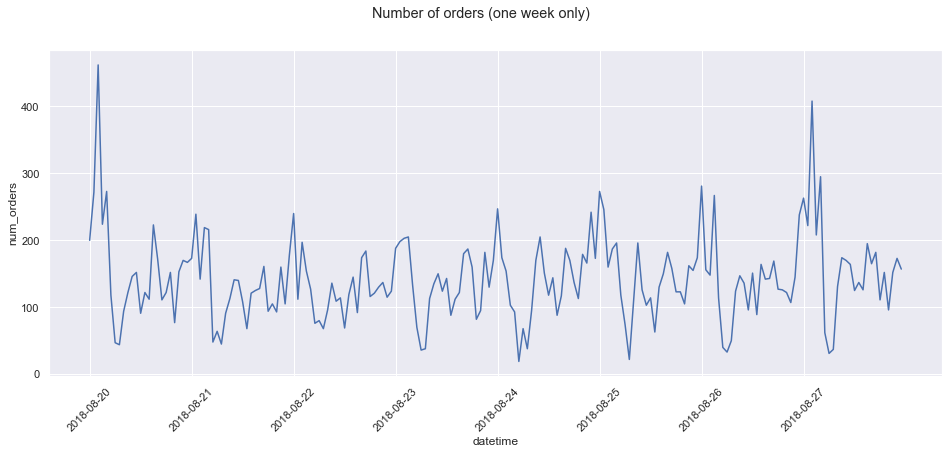

In [21]:
ts_plot(data[slice_bounds_week[0]:slice_bounds_week[1]],
        title='one week only',
        ticks='d')

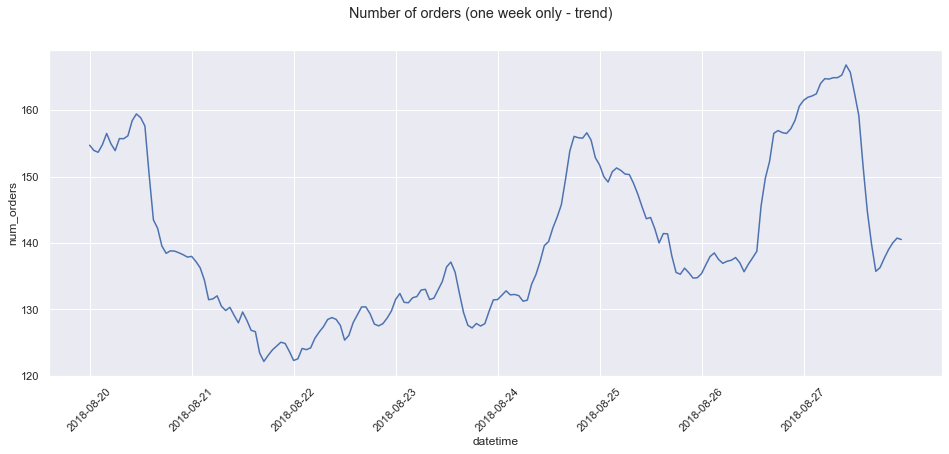

In [22]:
ts_plot(decomposed_trend[slice_bounds_week[0]:slice_bounds_week[1]],
        title='one week only - trend',
        ticks='d')

Больше всего вызовов - в первой половине дня в понедельник и во второй половине дня в пятницу и воскресенье. Меньше всего вызовов - во вторник, среду и четверг, т.е. в середине рабочей недели.

Динамика тренда в течение недели объясняется **привязкой к выходным**. Командировки, рабочие поездки чаще всего проводятся с понедельника по пятницу. Иногда - по четверг, если дела были завершены пораньше. Кто-то остаётся в городе на выходные или приезжает отдохнуть специально (особенно если город - туристический).

Чтобы сэкономить время, рейсы часто выбирают те, что вечером накануне, или те, что рано утром день-в-день.

Всё это мы и видим на графике.

In [23]:
decomposed_seasonal[slice_bounds_week[0]:slice_bounds_week[1]].num_orders.describe()

count    192.000000
mean       0.000000
std       26.222000
min      -59.182671
25%      -11.747733
50%        3.261489
75%       14.668963
max       60.248112
Name: num_orders, dtype: float64

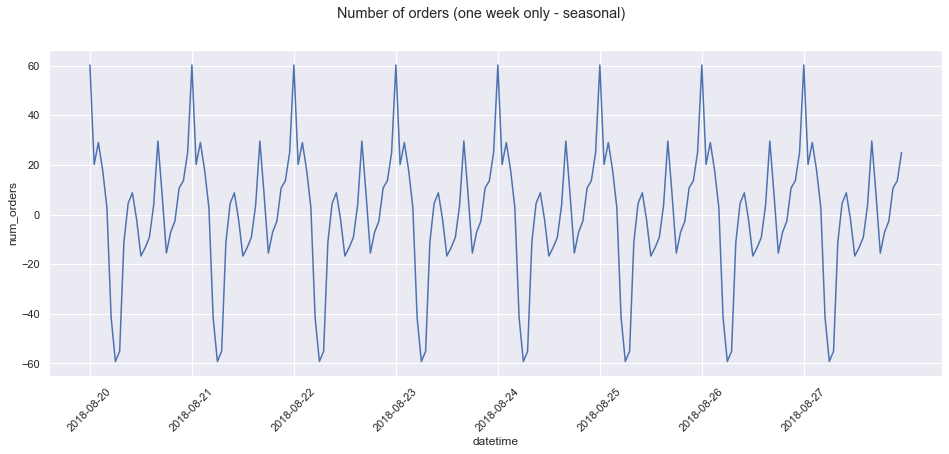

In [24]:
ts_plot(decomposed_seasonal[slice_bounds_week[0]:slice_bounds_week[1]],
        title='one week only - seasonal',
        ticks='d')

Рассмотрим отдельно типичные сутки (их сезонную составляющую).

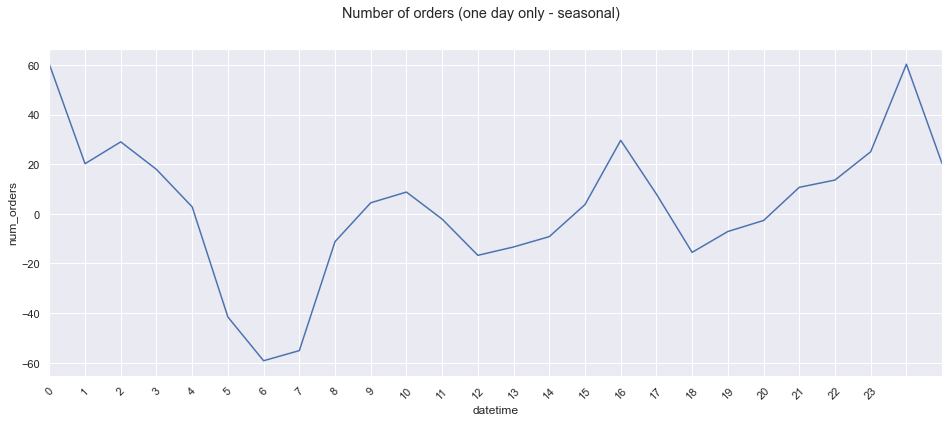

In [25]:
ts_plot(decomposed_seasonal['2018-08-20 00:00':'2018-08-21 01:00'],
        title='one day only - seasonal',
        ticks='h')

Меньше всего заказов - ранним утром (05-07 часов), больше всего - в часы пик (09-10 и около 16) и поздно вечером (23-01).

Таким образом, разница в количестве заказов, зависящая только от того, **который час**, может достигать 120 единиц в течение суток. Это сопоставимо со **среднесуточным** количеством заказов за рассматриваемую неделю (142 заказа).

Сезонность (суточный цикл) оказывает **весьма значительное** влияние на количество заказов и вполне может приводить как к **простоям** (это всё равно неизбежно) так и к **превышению возможностей** сервиса (а вот это уже - упущенная выгода).

In [26]:
decomposed_resid[slice_bounds_week[0]:slice_bounds_week[1]].num_orders.describe()

count    192.000000
mean       1.659614
std       45.120845
min      -74.483996
25%      -27.764562
50%       -4.158517
75%       18.457574
max      279.371423
Name: num_orders, dtype: float64

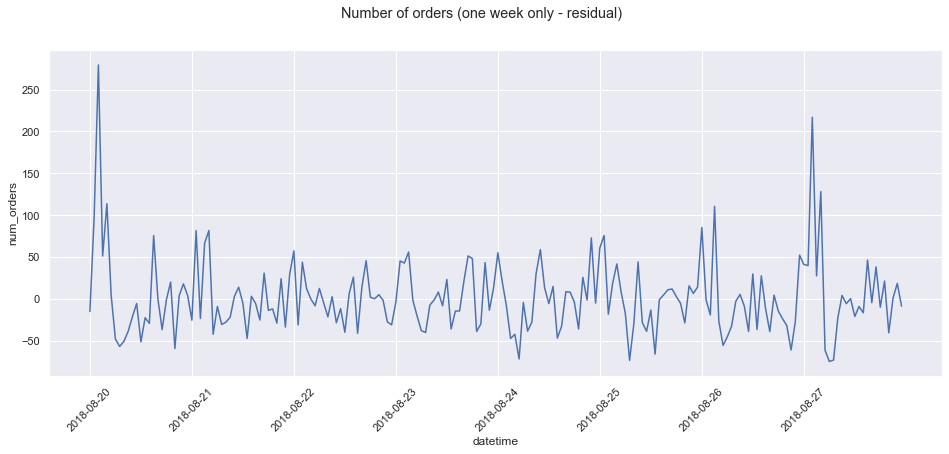

In [27]:
ts_plot(decomposed_resid[slice_bounds_week[0]:slice_bounds_week[1]],
        title='one week only - residual',
        ticks='d')

Шум вносит весьма значительный вклад **в моменте**. В среднем же его влияние - мало. Т.е. шум приводит примерно к тем же проблемам, что и суточные колебания.

Поскольку, в отличие от сезонности, шум **непредсказуем** во времени, "бороться" с ним, скорее всего, придётся статистическими методами (анализ распределения с целью вычислить необходимое число резервных автомобилей, покрывающих положительные выбросы этого шума).

Шум - это случайная, необъяснённая составляющая, и фундаментально модель её **вряд ли** сможет спрогнозировать эффективно.

### Вывод по проведённому анализу

Рассматриваемый временной ряд - достаточно **однообразный**, что позволило анализировать его в различных масштабах: 1 месяц, 1 неделя, 1 сутки (последнее - только для сезонной составляющей).

Тренд - восходящий: число заказов растёт, компания развивается. Сезонная составляющая и шум оказывают **существенное** влияние на число заказов, что говорит об актуальности задачи, поставленной в ТЗ.

Длительность сезона (период цикла) - 1 сутки: можно говорить о циклических **суточных** колебаниях числа заказов. Диапазон колебаний: &plusmn;60 заказов в сутки. Их легко учесть, поскольку они **строго периодичны**.

Диапазон шума, как правило, &plusmn;50 заказов в сутки. Но это - средние максимумы и минимумы (оценочно по графику), и иногда выбросы могут быть более значительными.

Трендовая составляющая также обладает выраженной, но не строгой цикличностью (длительность периода - **1 неделя**). Такая цикличность обусловлена привязкой авиапутешествий (такси работает в аэропорту) к определённым дням недели.

В целом, рассматриваемый временной ряд можно охарактеризовать как более-менее **предсказуемый**. Применение моделей машинного обучения для прогноза будущих значений может дать неплохой результат (лучше, чем наивный прогноз).

# 3. Обучение

## Вводная часть

Согласно ТЗ, необходимо спрогнозировать количество заказов такси на следующий час.

Поставленная задача - задача регрессии.

Будем рассматривать три алгоритма:
* *Random Forest*;
* *Linear Regression*;
* *Light GBM*.

По алгоритмам *Random Forest* и *Light GBM* построим несколько моделей с различными гиперпараметрами и выберем лучшие. Лучшие затем протестируем на тестовой выборке.

Поскольку имеется тренд, а также значительное влияние оказывает шум, необходимо применять кросс-валидацию, чтобы уменьшить влияние этих факторов.

Размер тестовой выборки - 10% от исходной. Размер валидирующей выборки (каждой) - 10% от исходной. Количество валидирующих выборок - 3.

#### Функция *gridsearch_cv_ts*

Алгоритмы, обеспечивающие выполнение машинного обучения, реализованы в функции *gridsearch_cv_ts*:
* разделение датасета на выборки;
* подбор лучших гиперпараметров с применением кросс-валидации;
* тестирование лучшей модели на тестовой выборке.

Перебор гиперпараметров и кросс-валидация развёрнуты вручную. Поскольку мы имеем дело с временным рядом, кросс-валидация имеет некоторые особенности: нельзя "показывать" модели будущие значения и, следовательно, нельзя их перемешивать. Принцип разбиения на выборки для кросс-валидации и тестирования представлен на схеме:

- | ---- train ---- | - valid - |
- | ---------- train ---------- | - valid - |
- | ---------------- train ---------------- | - valid - |
- | ---------------------- train ---------------------- | - test -- |

Результаты расчёта - возвращаются, а также выводятся на экран.

## Функции

In [28]:
# The function implements searching for the best model using cross-validation;
# returns: dictionary with the parameters of the best model,
#          RMSE of the best model on the validation sample,
#          RMSE of the best model on the test sample

def gridsearch_cv_ts(model, ts_data, params, cv=3, test_size=0.1, valid_size=0.1, target_name='num_orders',
                     testing_mode=False, on_display=True, output=True, rmse_required=48.0):
    
    # indexes of the train, the valid and the test samples
    test_length = int(np.ceil(test_size * len(ts_data.index)))
    valid_length = int(np.ceil(valid_size * len(ts_data.index)))

    index_train = ts_data.index[:(len(ts_data.index) - test_length)]
    index_test = ts_data.index[(len(ts_data.index) - test_length):]

    index_train_cv = []
    index_valid_cv = []
    for i in range(cv):
        bound = len(index_train) - (cv-i) * valid_length
        index_train_cv.append(index_train[:bound])
        index_valid_cv.append(index_train[bound:(bound + valid_length)])

    # splitting into the features (X) and the target (y)
    X = data.drop(columns=[target_name])
    y = data[target_name]
    
    # validation
    best_params_valid = {}
    best_rmse_valid = 0.0

    if testing_mode == False:
        
        # the list which contains all the combinations of the values of the lists in the dict
        combinations_list = []
        combinations = [None] * len(params)
        for combinations in itertools.product(*params.values()):
            combinations_list.append(combinations)

        # the dataframe for the combinations
        combinations_df = pd.DataFrame(data=combinations_list, columns=params.keys())

        # the list of dicts directly passed into the model using 'set_params' method: (**params_dicts[i])
        params_dicts = combinations_df.to_dict('records')      # notice: 'records' is a splitting method

        results = combinations_df.copy()
        
        if len(params) > 0:
            # cross-validation
            results['rmse'] = None

            # model parameters loop
            for i in range(len(params_dicts)):
                model.set_params(**params_dicts[i])
                metrics_cv = []

                # cross-validation loop
                for j in range(cv):
                    X_train = X.loc[index_train_cv[j]]
                    X_valid = X.loc[index_valid_cv[j]]
                    y_train = y.loc[index_train_cv[j]]
                    y_valid = y.loc[index_valid_cv[j]]

                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_valid)

                    metrics_cv.append(np.sqrt(mean_squared_error(y_valid, y_pred)))

                results.loc[i, 'rmse'] = np.mean(metrics_cv)
            
            # saving the best results
            results.rmse = results.rmse.astype('float')
            best_params_valid = results.loc[results.rmse.idxmin()].drop('rmse').astype('int').to_dict()
            best_rmse_valid = results.loc[results.rmse.idxmin()].rmse
        
        else:
            # single validation
            X_train = X.loc[index_train_cv[cv-1]]
            X_valid = X.loc[index_valid_cv[cv-1]]
            y_train = y.loc[index_train_cv[cv-1]]
            y_valid = y.loc[index_valid_cv[cv-1]]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            
            # saving the result
            best_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred))

    # testing
    X_train = X.loc[index_train]
    X_test  = X.loc[index_test]
    y_train = y.loc[index_train]
    y_test  = y.loc[index_test]
    y_pred  = None
    
    if testing_mode == True:
        best_params_valid = params
        model.set_params(**best_params_valid)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # naive prediction
    y_naive = y_test.shift()
    y_naive[0] = y_train[-1]
    y_naive = y_naive.astype('int')
    rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))
    
    # displaying
    if on_display == True:
        if testing_mode == False:
            print('cross-validation:')
            if len(params) > 0:
                print(f'parameters of the best model: {best_params_valid}')
            print('RMSE on the validation sample: {:3.2f}'.format(best_rmse_valid))
        
        else:
            print('testing:\nRMSE on the test sample:       {:3.2f}'.format(rmse_test))
    
        print('RMSE required:                 {:3.2f}'.format(rmse_required))
        print('RMSE for the naive prediction: {:3.2f}'.format(rmse_naive))
    
    # output
    if output == True:
        if testing_mode == False:
            return best_params_valid, best_rmse_valid
        else:
            y_test = pd.DataFrame(data=y_test, columns=['num_orders'])
            y_pred = pd.DataFrame(data=y_pred, index=y_test.index, columns=['num_orders'])
            
            return y_test, y_pred

In [29]:
# The function adds lag features and moving average into the original dataset

def features_adding(ts_original, n_lags=5, ma_window_size=5):
    data = ts_original.copy()

    # lag features
    for i in range(1, n_lags+1):
        data[f'lag_{i}'] = data.num_orders.shift(i)
    lag_columns = data.columns[data.columns.str.contains('lag')]

    # moving average
    data['ma'] = data.num_orders.shift().rolling(ma_window_size).mean()

    # dropping NaNs and correcting dtypes
    data.dropna(inplace=True)
    data[lag_columns] = data[lag_columns].astype('int')
    
    return data

In [30]:
# The function displays current results while the models are being computed
def current_results_displaying(results_array):
    print('lag={:2}; win={:2}, rmse={:3.4f}, params={}'
          .format(results_array[-1][0],
                  results_array[-1][1],
                  results_array[-1][2],
                  results_array[-1][3]
                 )
         )

In [31]:
# The function searches the lowest RMSE and returns all the parameters
def lowest_rmse(results):
    df_results = pd.DataFrame(results, columns=['lags', 'window_size', 'rmse', 'parameters'])
    print(df_results.loc[df_results.rmse.idxmin()])
    return df_results.loc[df_results.rmse.idxmin()]

##  Создание признаков

Создадим три типа признаков:
* календарные;
* отстающие значения;
* скользящее среднее.

Календарные признаки отражают сезонность. У нас имеются две сезонности: недельная и внутридневная. Следовательно, нам необходимы признаки: день недели; час**. Оба признака - категориальные, поэтому их тип данных сразу приведём к строковому.

Отстающие значения создадим с помощью сдвига исходного временного ряда.

Скользящее среднее не должно учитывать текущее значение ряда, поэтому его будем рассчитывать на данных, сдвинутых по индексу на одну позицию (на 1 час) вперёд.

Сохраним исходный датасет в отдельной переменной.

*В процессе исследования стало очевидно, что двух календарных признаков недостаточно, и были добавлены ещё два признака: месяц; день месяца.*

In [32]:
data_original = data.copy()

### Календарные признаки

Выбор календарных признаков зависит от свойств самого датасета, поэтому их мы добавим единственный раз в самом начале.

Создадим рабочую копию исходного датасета и добавим в неё календарные признаки - день недели, час, месяц, день месяца.

In [33]:
data = data_original.copy()
cat_cols = ['weekday', 'hour', 'month', 'day']

for col in cat_cols:
    data[col] = getattr(data.index, col)
    
d(data.head(3))
data.dtypes

,num_orders,weekday,hour,month,day
datetime,,,,,
2018-03-01 00:00:00,124,3,0,3,1
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,2,3,1


num_orders    int64
weekday       int64
hour          int64
month         int64
day           int64
dtype: object

Добавленные признаки - категориальные.

Для *Random Forest* и *Linear Regression* приведём их к строковому типу данных, а затем преобразуем методом *One-Hot Encoding*.

In [34]:
data_str = data.copy()

for col in cat_cols:
    data_str[col] = data_str[col].astype('str')

data_str.dtypes

num_orders     int64
weekday       object
hour          object
month         object
day           object
dtype: object

In [35]:
data_ohe = data_str.copy()

data_ohe = pd.get_dummies(data_ohe, drop_first=True)
data_ohe.columns

Index(['num_orders', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'hour_1', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_2', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_2', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_3',
       'day_30', 'day_31', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9'],
      dtype='object')

Для *Light GBM* укажем только номера столбцов категориальных признаков.

In [36]:
cat_cols_numbers = pd.Series(data.columns)
cat_cols_numbers = cat_cols_numbers[cat_cols_numbers.isin(cat_cols) == True].index.tolist()
cat_cols_numbers

[1, 2, 3, 4]

### Отстающие значения и скользящее среднее

Глубину отстающих значений и размер окна скользящего среднего необходимо подбирать **в цикле**, - оптимизация признаков является частью процесса оптимизации модели (так как модель выполняет расчёт на основе тех данных, которые ей подадут на вход). Алгоритм добавления признаков реализован в функции *features_adding*. 

Подбор признаков **неразрывно** связан с процессом обучения модели и, в частности, с подбором гиперпараметров: последний выполняется для каждого набора признаков, т.е. выполняется внутри цикла подбора признаков. Следовательно, отстающие значения и скользящее среднее мы будем создавать отдельно для каждого алгоритма обучения, подбирая оптимальную конфигурацию датасета.

Сформируем сетку параметров признаков (параметров датасета).

In [37]:
params_dataset = {
    'lags': np.arange(6, 13, 3),
    'window_size': np.arange(6, 13, 3)
}

params_dataset

{'lags': array([ 6,  9, 12]), 'window_size': array([ 6,  9, 12])}

## Обучение и валидация моделей

### Random Forest

Сформируем сетку гиперпараметров.

In [38]:
params_rf = {
    'max_depth': np.linspace(12, 24, 4, dtype='int'),
    'min_samples_leaf': np.linspace(1, 2, 2, dtype='int')
}

params_rf

{'max_depth': array([12, 16, 20, 24]), 'min_samples_leaf': array([1, 2])}

Подберём лучшую конфигурацию датасета для алгоритма *Random Forest* и настроим модель.

In [39]:
%%time

results_rf = []

for lag in params_dataset['lags']:
    for win in params_dataset['window_size']:
        data_rf = features_adding(data_ohe, n_lags=lag, ma_window_size=win)
        best_params_rf, rmse_valid_rf = gridsearch_cv_ts(model=RandomForestRegressor(n_estimators=100,
                                                                                     n_jobs=-1,
                                                                                     random_state=r_state
                                                                                    ),
                                                         ts_data=data_rf,
                                                         params=params_rf,
                                                         on_display=False
                                                        )
        results_rf.append([lag, win, rmse_valid_rf, best_params_rf])
        current_results_displaying(results_rf)

lag= 6; win= 6, rmse=27.6657, params={'max_depth': 20, 'min_samples_leaf': 2}
lag= 6; win= 9, rmse=27.6147, params={'max_depth': 16, 'min_samples_leaf': 2}
lag= 6; win=12, rmse=27.5643, params={'max_depth': 20, 'min_samples_leaf': 2}
lag= 9; win= 6, rmse=27.6147, params={'max_depth': 16, 'min_samples_leaf': 2}
lag= 9; win= 9, rmse=27.6147, params={'max_depth': 16, 'min_samples_leaf': 2}
lag= 9; win=12, rmse=27.5643, params={'max_depth': 20, 'min_samples_leaf': 2}
lag=12; win= 6, rmse=27.5643, params={'max_depth': 20, 'min_samples_leaf': 2}
lag=12; win= 9, rmse=27.5643, params={'max_depth': 20, 'min_samples_leaf': 2}
lag=12; win=12, rmse=27.5643, params={'max_depth': 20, 'min_samples_leaf': 2}
Wall time: 1min 23s


Значения метрик очень близки между собой. Подробнее об этом - в выводе.

Найдём самую точную модель - с самым малым RMSE.

In [40]:
best_rf = lowest_rmse(results_rf)

lags                                                  6
window_size                                          12
rmse                                            27.5643
parameters     {'max_depth': 20, 'min_samples_leaf': 2}
Name: 2, dtype: object


### Linear Regression

Подберём лучшую конфигурацию датасета для алгоритма *Linear Regression* и настроим модель. Настраиваемых гиперпараметров у данного алгоритма нет, поэтому сетка не потребуется.

In [41]:
%%time

results_lr = []

for lag in params_dataset['lags']:
    for win in params_dataset['window_size']:
        data_lr = features_adding(data_ohe, n_lags=lag, ma_window_size=win)
        best_params_lr, rmse_valid_lr = gridsearch_cv_ts(model=LinearRegression(),
                                                         ts_data=data_lr,
                                                         params={},
                                                         on_display=False
                                                        )
        results_lr.append([lag, win, rmse_valid_lr, best_params_lr])
        current_results_displaying(results_lr)

lag= 6; win= 6, rmse=46.8009, params={}
lag= 6; win= 9, rmse=46.8057, params={}
lag= 6; win=12, rmse=46.7978, params={}
lag= 9; win= 6, rmse=46.8057, params={}
lag= 9; win= 9, rmse=46.8057, params={}
lag= 9; win=12, rmse=46.7978, params={}
lag=12; win= 6, rmse=46.7978, params={}
lag=12; win= 9, rmse=46.7978, params={}
lag=12; win=12, rmse=46.7978, params={}
Wall time: 424 ms


Найдём самую точную модель.

In [42]:
best_lr = lowest_rmse(results_lr)

lags                 6
window_size         12
rmse           46.7978
parameters          {}
Name: 2, dtype: object


### Light GBM

Сформируем сетку гиперпараметров.

In [43]:
params_gb = {
    'max_depth': np.linspace(8, 16, 3, dtype='int'),
    'min_data_in_leaf': np.geomspace(8, 64, 4, dtype='int')
}

params_gb

{'max_depth': array([ 8, 12, 16]), 'min_data_in_leaf': array([ 7, 16, 31, 63])}

Подберём лучшую конфигурацию датасета для алгоритма *Random Forest* и настроим модель.

In [44]:
%%time

results_gb = []

for lag in params_dataset['lags']:
    for win in params_dataset['window_size']:
        data_gb = features_adding(data, n_lags=lag, ma_window_size=win)
        best_params_gb, rmse_valid_gb = gridsearch_cv_ts(model=lgb.LGBMRegressor(n_estimators=200,
                                                                                 cat_feature=cat_cols_numbers,
                                                                                 n_jobs=-1,
                                                                                 random_state=r_state
                                                                                ),
                                                         ts_data=data_gb,
                                                         params=params_gb,
                                                         on_display=False
                                                        )
        results_gb.append([lag, win, rmse_valid_gb, best_params_gb])
        current_results_displaying(results_gb)

lag= 6; win= 6, rmse=37.6193, params={'max_depth': 8, 'min_data_in_leaf': 7}
lag= 6; win= 9, rmse=37.6109, params={'max_depth': 8, 'min_data_in_leaf': 7}
lag= 6; win=12, rmse=37.6770, params={'max_depth': 12, 'min_data_in_leaf': 31}
lag= 9; win= 6, rmse=37.6109, params={'max_depth': 8, 'min_data_in_leaf': 7}
lag= 9; win= 9, rmse=37.6109, params={'max_depth': 8, 'min_data_in_leaf': 7}
lag= 9; win=12, rmse=37.6770, params={'max_depth': 12, 'min_data_in_leaf': 31}
lag=12; win= 6, rmse=37.6770, params={'max_depth': 12, 'min_data_in_leaf': 31}
lag=12; win= 9, rmse=37.6770, params={'max_depth': 12, 'min_data_in_leaf': 31}
lag=12; win=12, rmse=37.6770, params={'max_depth': 12, 'min_data_in_leaf': 31}
Wall time: 2min 25s


Найдём самую точную модель.

In [45]:
best_gb = lowest_rmse(results_gb)

lags                                                 6
window_size                                          9
rmse                                           37.6109
parameters     {'max_depth': 8, 'min_data_in_leaf': 7}
Name: 1, dtype: object


## Вывод по обучению моделей

Выполнена подготовка данных в части создания признаков. Календарные признаки - **единые** для всех алгоритмов. Отстающие значения и скользящее среднее (соответственно глубина и размер окна) для каждого алгоритма подбирались **индивидуально** (по сетке). Календарные признаки, будучи категориальными, приведены к строковому типу данных и преобразованы методом OHE.

Для обучения использовались три алгоритма: *Random Forest*, *Linear Regression*, *Light GBM*. По алгоритмам *Random Forest* и *Light GBM* было обучено несколько разных моделей с различными значениями гиперпараметров, из которых затем были выбраны лучшие. Оценка качества выполнялась с применением кросс-валидации (с учётом особенностей её применения к временному ряду). Метрика качества - *RMSE*. Разбиение на выборки, кросс-валидация, а также тестирование развёрнуты вручную и реализованы в **функции** *gridsearch_cv_ts*.

Для всех трёх алгоритмов выполнено варьирование состава признаков. Из исходного датасета формировались различные **модифицированные** датасеты, куда добавлялись **новые** признаки: отстающие значения и скользящее среднее (в соответствии с сеткой параметров).

Наименьшее значение *RMSE* на **валидационной** выборке получилось у модели *Random Forest* (*RMSE* = 28). Средний результат - у *Light GBM* (*RMSE* = 38). Самый слабый результат - у *Linear Regression* (*RMSE* = 47). Требуемый результат согласно ТЗ: *RMSE* &le; 48.

В процессе исследования обнаружена следующая особенность. Качество предсказания практически полностью зависит только от **состава календарных признаков**. Остальные факторы почти никак не отражаются на значении метрики *RMSE*: из представленных результатов видно, что метрика изменяется в пределах нескольких сотых. Вот примерный перечень исследованных факторов, которые **не оказали влияния** на качество предсказания (некоторые моменты были исследованы, но не вошли в работу):
* количество (глубина сдвига) отстающих значений (до 48);
* размер окна скользящего среднего (до 48);
* состав и диапазон изменяемых гиперпараметров модели (при наличии);
* тип данных календарных признаков (int; str);
* преобразование календарных признаков методом One-Hot Encoding (с ним и без него);
* добавление в качестве признака тренда или сезонности (*decomposed.trend*; *decomposed.seasonal*);
* уменьшение размера валидационной выборки вдвое с целью увеличить обучающую выборку (0.30 -> 0.15).

Возможно, так проявляет себя случайная составляющая временного ряда, которая в рассматриваемом наборе данных выражена достаточно **сильно** (см. предыдущий раздел). Шум не настолько значителен, чтобы ряд вообще невозможно было прогнозировать - его прогнозировать вполне можно. Однако, выявился вот такой эффект.

Таким образом, благоприятно сказывается на качестве прогноза добавление только таких признаков, которые несут в себе **новую информацию**. А такие признаки, как отстающие значения и скользящее среднее, представляют собой лишь видоизменённую информацию, которая уже и так имеется в данных. То же касается и различного рода параметров (как параметров признаков, так и гиперпараметров моделей): они лишь представляют имеющуюся в данных информацию под разными углами, помогая модели распознать имеющиеся закономерности. Но если возможности распознавания уже исчерпаны, то таким путём на результат повлиять больше нельзя.

Интерпретируя простыми словами, ситуацию можно описать так: модель **уже увидела всё**, что могла увидеть, и, несмотря на изменение тех или иных настроек, ничего **нового** в представленных данных она уже разглядеть **не способна**. А стоит привнести новые данные - ситуация сразу улучшается: теперь у модели снова есть, с чем работать.

# 4. Тестирование

Выполним тестирование лучших моделей на тестовом наборе данных. Алгоритм тестирования реализован в функции *gridsearch_cv_ts*.

### Random Forest

In [46]:
y_test_rf, y_pred_rf = gridsearch_cv_ts(model=RandomForestRegressor(n_estimators=100,
                                                                    n_jobs=-1,
                                                                    random_state=r_state
                                                                   ),
                                        ts_data=features_adding(data_ohe,
                                                                n_lags=best_rf['lags'],
                                                                ma_window_size=best_rf['window_size']),
                                        params=best_rf['parameters'],
                                        testing_mode=True
                                       )

testing:
RMSE on the test sample:       43.36
RMSE required:                 48.00
RMSE for the naive prediction: 58.92


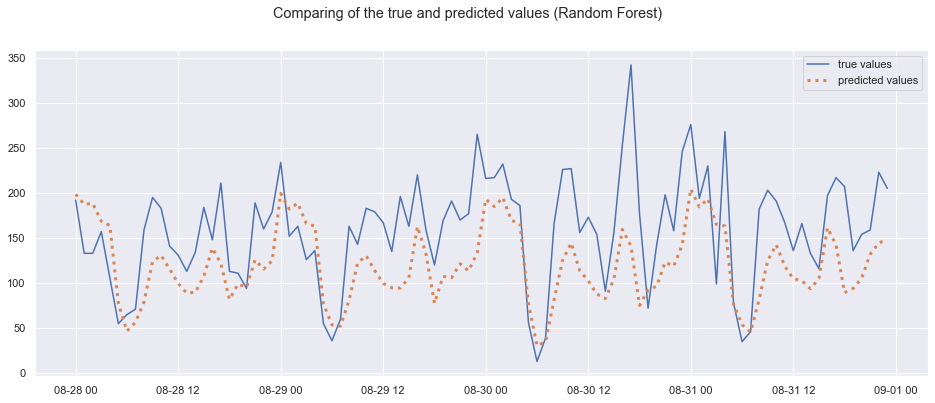

In [47]:
bound = '2018-08-28'
plots_comparing(y_test_rf[bound:],
                'true values',
                y_pred_rf[bound:],
                'predicted values',
                'Comparing of the true and predicted values (Random Forest)'
               )

### Linear Regression

In [48]:
y_test_lr, y_pred_lr = gridsearch_cv_ts(model=LinearRegression(),
                                        ts_data=features_adding(data_ohe,
                                                                n_lags=best_lr['lags'],
                                                                ma_window_size=best_lr['window_size']),
                                        params=best_lr['parameters'],
                                        testing_mode=True
                                       )

testing:
RMSE on the test sample:       63.81
RMSE required:                 48.00
RMSE for the naive prediction: 58.92


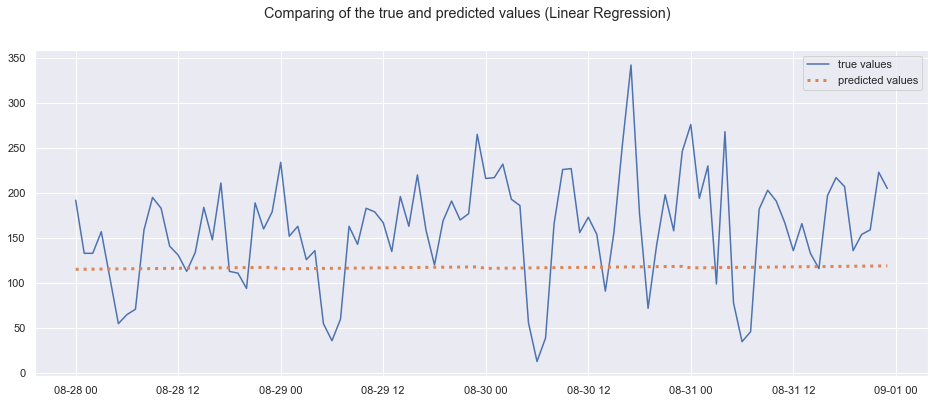

In [49]:
bound = '2018-08-28'
plots_comparing(y_test_lr[bound:],
                'true values',
                y_pred_lr[bound:],
                'predicted values',
                'Comparing of the true and predicted values (Linear Regression)'
               )

### Light GBM

In [50]:
y_test_gb, y_pred_gb = gridsearch_cv_ts(model=lgb.LGBMRegressor(n_estimators=200,
                                                                cat_feature=cat_cols_numbers,
                                                                n_jobs=-1,
                                                                random_state=r_state
                                                               ),
                                        ts_data=features_adding(data_ohe,
                                                                n_lags=best_gb['lags'],
                                                                ma_window_size=best_gb['window_size']),
                                        params=best_gb['parameters'],
                                        testing_mode=True
                                       )

testing:
RMSE on the test sample:       46.71
RMSE required:                 48.00
RMSE for the naive prediction: 58.92


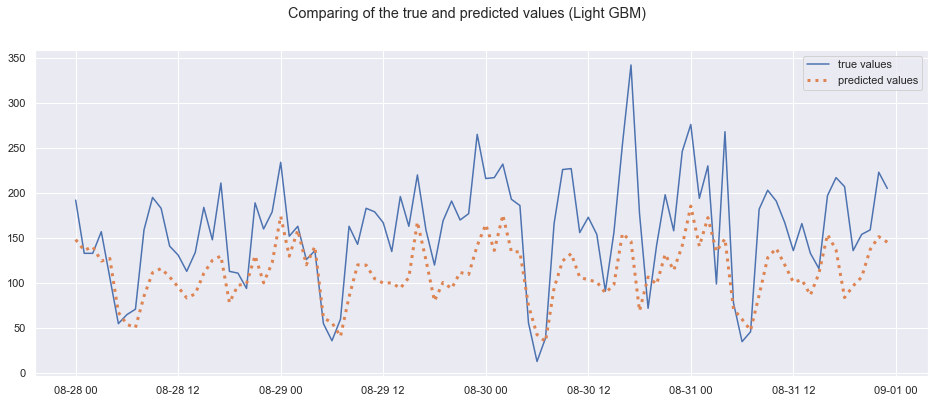

In [51]:
bound = '2018-08-28'
plots_comparing(y_test_gb[bound:],
                'true values',
                y_pred_gb[bound:],
                'predicted values',
                'Comparing of the true and predicted values (Light GBM)'
               )

## Вывод по тестированию моделей

Тестирование выполнено с помощью функции *gridsearch_cv_ts*.

На тестовой выборке **проверены** модели, показавшие наилучшие результаты (наименьшее значение метрики *RMSE*) на валидационной выборке. Выполнено сравнение полученных результатов как с требованиями **ТЗ**, так и с результатом **наивного** прогноза (заполнение предыдущим значением).

Наименьшее значение *RMSE* на тестовой выборке получилось у модели *Random Forest* (*RMSE* = 43). Средний результат - у *Light GBM* (*RMSE* = 47). Самый слабый результат - у *Linear Regression* (*RMSE* = 64). Требуемый результат согласно ТЗ: *RMSE* &le; 48. Наивный прогноз: *RMSE* = 59.

Модели *Random Forest* и *Light GBM* **удовлетворяют** требованиям ТЗ. Модель *Linear Regression* не только не удовлетворяет требованиям ТЗ, но и **не является адекватной**.

# Общий вывод

##### Анализ

Рассмотрены в различных масштабах составляющие временного ряда: тренд, сезонность, остаток (шум). Остаток (случайная величина) представляет собой достаточно весомую часть от общего числа заказов, что затрудняет прогнозирование. Но всё же не делает его невозможным: вид трендовой и сезонной составляющих дают основание полагать, что при помощи машинного обучения всё-таки возможно уложиться в требования ТЗ, а также превзойти по точности наивный прогноз.

##### Обучение

Выполнено обучение различных моделей с применением кросс-валидации (алгоритмы *Random Forest*, *Linear Regression*, *Light GBM*). Обучение выполнялось как при различных значениях гиперпараметров, так и на различных наборах данных (модификации исходного датасета с тем или иным набором признаков).

На валидационной выборке лучший результат - у *Random Forest*, худший - у *Linear Regression*, посередине - *Light GBM*. Все три модели удовлетворяют требованиям ТЗ.

В процессе оптимизации выяснилось, что на результат (значение метрики *RMSE*) существенное влияние оказывает только состав календарных признаков: чем больше различных календарных признаков добавлено в датасет, тем более точный прогноз делает обученная на таком датасете модель. Остальные факторы влияют пренебрежимо мало.

Вероятно, причиной тому является шум, содержащийся в данных в достаточно большом количестве. Но, тем не менее, удовлетворительные результаты удалось получить.

Причина нечувствительности к изменению большинства факторов также может заключаться и в том, что возникла ситуация, когда модель извлекла из данных всю полезную информацию, какую только можно было извлечь. То есть исчерпаны возможности не модели, а самого датасета. Чтобы продолжать улучшать качество прогноза, необходимо добавлять признаки, несущие в себе новую информацию. То есть не вычисленные из уже имеющихся, а именно новые, взятые извне.

В данном случае это были месяц и день месяца в дополнение к дню недели и часу (первые никак не связаны со вторыми; одни из других нельзя вычислить).

##### Тестирование

Лучшая модель - *Random Forest* (*RMSE* = 43). Второе место - *Light GBM* (*RMSE* = 47). Обе модели удовлетворяют требованиям ТЗ (*RMSE* &le; 48). Модель *Linear Regression* (*RMSE* = 64) не только не удовлетворяет требованиям ТЗ, но и не является адекватной (наивный прогноз: *RMSE* = 59).

Можно сделать вывод о том, что рассматриваемый временной ряд плохо описывается линейной функцией. А решающим деревом - хорошо.

Когда для прогнозирования временного ряда применяется модель на основе деревьев, необходимо помнить о тренде. Из-за наличия тренда прогнозы со временем будут всё больше и больше расходиться с реальностью (реальные данные "убегут" от прогнозов). Чтобы этого избежать, необходимо регулярно переобучать модель на свежих данных. Чем сильнее тренд, тем чаще следует выполнять переобучение и тем короче горизонт прогнозирования.

##### Заключение

Модель, построенная на основе алгоритма *Random Forest*, имеет самую высокую точность. Иные требования, условия, ограничения - отсутствуют. В частности, отсутствуют жёсткие рамки по скорости предсказания: прогноз будет выполняться не чаще, чем один раз в несколько минут, а время, требуемое для расчёта, составляет всего несколько секунд.

Таким образом, наиболее полно требованиям ТЗ соответствует модель на основе алгоритма *Random Forest*.

Модель рекомендуется к применению в компании.